The whold training and testing is on Google Colab. 

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = "/content/drive/My Drive/segnet/"
os.chdir(path)
os.listdir(path)

['lab2_test_data.h5',
 'lab2_train_data.h5',
 'vgg16_bn-6c64b313.pth',
 'results',
 'main_segnet_v1.ipynb',
 'weights',
 'main_bayesian_segnet_v1.ipynb']

In [3]:
!/opt/bin/nvidia-smi

Tue Feb 15 16:03:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    42W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# use this version to avoid bugs
!pip install torch-summary==1.4.4

# 0. parameters
## 0.parameters

In [5]:
import torch.utils.data as data
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import random

import cv2 as cv
from PIL import Image
import time

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
MODE = 'TRAIN' # set MODE='TEST' to test without training

n_epochs = 10 # training epochs
class_num = 34
batch_size = 24 # should be no less than 5
learning_rate = 2e-5
weight_decay = 5e-4
log_interval = 10
random_seed = 28
val_percent = 0.1 # training set : validation set = 9:1
torch.manual_seed(random_seed)
bn_momentum = 0.1  # momentum for batch normalization

cate_weight = [1/34]*34 # weight for each class
dir_pre_train_weights = "vgg16_bn-6c64b313.pth" # pre_train weights downloaded from https://download.pytorch.org/models/vgg16_bn-6c64b313.pth
dir_weights = "./weights"
dir_checkpoint = './checkpoints'


# 1.Implement a data loader class to handle the downloaded data. (5 points)
For more information on the dataset please refer to: CityScapes dataset. 

In [7]:
color_codes = h5py.File("lab2_test_data.h5", 'r')['color_codes']

In [8]:
# 'rgb' stores the raw images, while 'seg' stores segmentation maps
class DataFromH5File(data.Dataset):
    def __init__(self, filepath):
        h5File = h5py.File(filepath, 'r')
        # self.color_codes = h5File['color_codes']
        self.rgb = h5File['rgb']
        self.seg = h5File['seg']
        
    def __getitem__(self, idx):
        label = torch.from_numpy(self.seg[idx]).float()
        data = torch.from_numpy(self.rgb[idx]).float()
        data = data/255.0 # normalization
        data = data.permute(2,0,1) # change the image channels into （channel, width, height）
        return data, label
    
    def __len__(self):
        assert self.rgb.shape[0] == self.seg.shape[0], "Wrong data length" # robustness
        return self.rgb.shape[0]

In [9]:
# load training data from lab2_train_data.h5
dataset = DataFromH5File("lab2_train_data.h5")
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val

# split train & val
train, val = data.random_split(dataset, [n_train, n_val])
train_loader = data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last = True)
val_loader = data.DataLoader(dataset=val, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last = True) # drop_last=True

# load testing data from lab2_test_data.h5
testset = DataFromH5File("lab2_test_data.h5")
test_loader = data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [10]:
# test the data loader
for step, (x, y) in enumerate(train_loader):
    print(x.min(),x.max())
    print(y.min(),y.max())
    print(step)
    break

print(len(train_loader), len(val_loader), len(test_loader)) # 669 74 125 when batch_size==4

tensor(0.) tensor(1.)
tensor(0.) tensor(33.)
0
111 12 21


# 2. Define the model. Provide a schematic of your architecture depicting its overall structure and the relevant parameters. (20 points)

## 2.1 Define the model.
Badrinarayanan et al. proposed **SegNet**.    
Paper link:https://arxiv.org/pdf/1511.00561.pdf   
Kendall et al. made some improvements and proposed **Bayesian SegNet**.   
Paper link:https://arxiv.org/pdf/1511.02680.pdf

In [11]:
# encoder
class Encoder(nn.Module):
    def __init__(self, input_channels):
        super(Encoder, self).__init__()

        self.enco1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU()
        )
        self.enco2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU()
        )
        self.enco3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU()
        )
        self.enco4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU()
        )
        self.enco5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(p=0.5)


    def forward(self, x):
        id = []

        x = self.enco1(x)
        x, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True) 
        id.append(id1)
        x = self.enco2(x)
        x, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id2)
        x = self.enco3(x)
        x, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id3)
        x = self.dropout(x) 
        x = self.enco4(x)
        x, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id4)
        x = self.dropout(x) 
        x = self.enco5(x)
        x, id5 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)
        id.append(id5)
        x = self.dropout(x) 

        return x, id


# encoder + decoder
class BayesianSegNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(BayesianSegNet, self).__init__()

        self.weights_new = self.state_dict()
        self.encoder = Encoder(input_channels)

        self.deco1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU()
        )
        self.deco2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU()
        )
        self.deco3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU()
        )
        self.deco4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU()
        )
        self.deco5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(),
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1), 
            nn.Softmax() # softmax
        )
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        x, id = self.encoder(x)

        x = F.max_unpool2d(x, id[4], kernel_size=2, stride=2)
        x = self.deco1(x)
        x = self.dropout(x)
        x = F.max_unpool2d(x, id[3], kernel_size=2, stride=2)
        x = self.deco2(x)
        x = self.dropout(x)
        x = F.max_unpool2d(x, id[2], kernel_size=2, stride=2)
        x = self.deco3(x)
        x = self.dropout(x)
        x = F.max_unpool2d(x, id[1], kernel_size=2, stride=2)
        x = self.deco4(x)
        x = F.max_unpool2d(x, id[0], kernel_size=2, stride=2)
        x = self.deco5(x)

        return x

    # delete weights of three fc layers
    def load_weights(self, weights_path):
        weights = torch.load(weights_path)
        del weights["classifier.0.weight"]
        del weights["classifier.0.bias"]
        del weights["classifier.3.weight"]
        del weights["classifier.3.bias"]
        del weights["classifier.6.weight"]
        del weights["classifier.6.bias"]

        names = []
        for key, value in self.encoder.state_dict().items():
            if "num_batches_tracked" in key:
                continue
            names.append(key)

        for name, dict in zip(names, weights.items()):
            self.weights_new[name] = dict[1]

        self.encoder.load_state_dict(self.weights_new)

## 2.2 Provide a schematic of your architecture depicting its overall structure and the relevant parameters.


![1644925819(1).png](https://s2.loli.net/2022/02/15/getsErVJbiFRwfC.png)
$$\rm Figure 1.model\; architecture$$ 
$$\rm As\; shown\; above,\; the\; encoder\; of\; Bayesian\; SegNet\; is\; the\; same\; as\; VGG16\; without\; fc\; layers.\; Dropout\; is\; added\; to\; the\; last\; three\; convolution\; layers\; of\; the\; encoder,\; and\; the\; first\; three\; convolution\; layers\; of\; the\; decoder.$$     
$$
\rm Note:Kendall,\; A.,\; Badrinarayanan,\; V.,\; \&\; Cipolla,\; R.\; (2015). Bayesian\; segnet:\; Model\; uncertainty\; in\; deep\; convolutional\; encoder-decoder\; architectures\; for\; scene\; understanding.\; arXiv\; preprint\; arXiv:1511.02680.
$$  
 

In [12]:
from torchsummary import summary

In [13]:
model = BayesianSegNet(input_channels=3, output_channels=class_num) # RGB images so the input_channels=3
model = model.to(device)
x = torch.ones([batch_size, 3, 128, 256]) # input shape
x = x.to(device)
y = model(x)
print(y.shape) # output shape
summary(model, input_size=(3, 128, 256))

torch.Size([24, 34, 128, 256])
Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,792
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-7                  73,856
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 147,584
|    |    └─BatchNorm2d: 3-11            256
|    |    └─ReLU: 3-12                   --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-13                 295,168
|    |    └─BatchNorm2d: 3-14            512
|    |    └─ReLU: 3-15                   --
|    |    └─Conv2d: 3-16                 590,080
|    |   

Layer (type:depth-idx)                   Param #
├─Encoder: 1-1                           --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  1,792
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-7                  73,856
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 147,584
|    |    └─BatchNorm2d: 3-11            256
|    |    └─ReLU: 3-12                   --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-13                 295,168
|    |    └─BatchNorm2d: 3-14            512
|    |    └─ReLU: 3-15                   --
|    |    └─Conv2d: 3-16                 590,080
|    |    └─BatchNorm2d: 3-17           

# 3. Define the loss function and optimizer. (10 points)

In [14]:
import torch.optim as optim

In [15]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# cross entropy loss
# To cope with the sample imbalance between different categories, we assign different weights to them.
criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(np.array(cate_weight)).float()).cuda()

# 4. Train the network. (5 points)

In [16]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [17]:
model.load_weights(dir_pre_train_weights)

The segmentation challenge is evaluated using the mean Intersection over Union (mIoU) metric.         
Let $n$ denotes the number of classes, then 
$$
mIoU = \frac{TP}{TP + FP + FN}
=\frac{1}{n}\sum_{i = 1}^{n}\frac{p_{ii}}{\sum_{j=1}^{n}p_{ij}+\sum_{j=1}^{n}p_{ji}+p_{ii}}
$$

In [18]:
def mIoU(pred, target):
  mini = 1
  intersection = pred * (pred == target)

  # histogram
  area_inter, _ = np.histogram(intersection, bins=2, range=(mini, class_num))
  area_pred, _ = np.histogram(pred, bins=2, range=(mini, class_num))
  area_target, _ = np.histogram(target, bins=2, range=(mini, class_num))
  area_union = area_pred + area_target - area_inter

  # Intersection area should be smaller than Union area 
  assert (area_inter <= area_union).all(), "Intersection area should be smaller than Union area"

  rate = round(max(area_inter) / max(area_union), 4)
  return rate

In [19]:
def validate(epoch):
  val_pbar = tqdm(val_loader)
  for batch_idx, (data, target) in enumerate(val_pbar):
    output = model(data.to(device)).to('cpu') # np.histogram requires cpu type tensor
    target = target.squeeze().long()
    miou = mIoU(output.argmax(dim=1), target) # data.argmax(dim=1) represents the segmentation results
    val_pbar.set_description(f"Validation | Epoch: {epoch} | mIoU: {miou.item():.4f}")

In [20]:
def train(epoch):
  model.train()
  pbar = tqdm(train_loader)
  for batch_idx, (data, target) in enumerate(pbar):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    target = target.squeeze().long()
    # print('output shape=',output.shape)
    # print('target shape=',target.shape)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"Epoch: {epoch} | Loss: {loss.item():.4f}")
    if batch_idx % log_interval == 0:
        train_losses.append(loss.item())
        train_counter.append((batch_idx*batch_size) + ((epoch-1)*len(train_loader.dataset)))
        # save the parameters
        torch.save(model.state_dict(), '/content/drive/My Drive/segnet/weights/model.pth')
        torch.save(optimizer.state_dict(), '/content/drive/My Drive/segnet/weights/optimizer.pth')

In [28]:
if MODE == 'TEST':
  model.load_state_dict(torch.load('/content/drive/My Drive/segnet/weights/23_model.pth'))
else:
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    # validation
    if epoch % 4 == 0 or epoch == n_epochs: # or epoch==1:
      validate(epoch)

Epoch: 1 | Loss: 2.7144: 100%|██████████| 111/111 [01:16<00:00,  1.45it/s]
Epoch: 2 | Loss: 2.7186: 100%|██████████| 111/111 [01:17<00:00,  1.44it/s]
Epoch: 3 | Loss: 2.7321: 100%|██████████| 111/111 [01:15<00:00,  1.47it/s]
Epoch: 4 | Loss: 2.7204: 100%|██████████| 111/111 [01:15<00:00,  1.47it/s]
Validation | Epoch: 4 | mIoU: 0.7670: 100%|██████████| 12/12 [00:05<00:00,  2.20it/s]
Epoch: 5 | Loss: 2.7100: 100%|██████████| 111/111 [01:15<00:00,  1.46it/s]
Epoch: 6 | Loss: 2.7029: 100%|██████████| 111/111 [01:15<00:00,  1.48it/s]
Epoch: 7 | Loss: 2.7052: 100%|██████████| 111/111 [01:15<00:00,  1.46it/s]
Epoch: 8 | Loss: 2.7192: 100%|██████████| 111/111 [01:17<00:00,  1.44it/s]
Validation | Epoch: 8 | mIoU: 0.7668: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]
Epoch: 9 | Loss: 2.7356: 100%|██████████| 111/111 [01:17<00:00,  1.44it/s]
Epoch: 10 | Loss: 2.7221: 100%|██████████| 111/111 [01:14<00:00,  1.49it/s]
Validation | Epoch: 10 | mIoU: 0.7751: 100%|██████████| 12/12 [00:05<00:00,  

plots of the loss evolution

# 5. Test the resulting network on examples from an independent test set. Implement and present: (40 points)
a. Predictions for (μ, aleatoric, epistemic) .            
b. Visualizations for (μ, aleatoric, epistemic) on 5 different input examples.         
c. Comment briefly on how the model’s performance could be improved.          
d. Please save your code and results for submission.

## 5.1 Predictions and visualizations for $(\mu,aleatoric,epistemic)$

In [30]:
from scipy.stats import entropy

In [31]:
# color the img according to the color_codes with elegant coding
def color(src):
  ret = np.zeros((src.shape[0], src.shape[1], 3))
  for i in range(class_num):
    ret[src==i] = color_codes[i]
  return ret

# visualize the segmentation results of 5 random test samples
def visualize():
  rand_idx = random.randint(0,len(test_loader)-1) # random test example idx
  
  for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == rand_idx:
      data = data.to(device)
      n_samples = 20 # number of bayesian dropout samples

      for i in range(5):
        outputs = torch.Tensor([model(data[i].unsqueeze(0)).to('cpu').detach().numpy() for _ in range(n_samples)])

        output = torch.mean(outputs, 0).squeeze() # mu
        aleatoric = entropy(output*255, axis=0)
        episdemic = torch.std(outputs, axis=0).squeeze().mean(0)
        output = output.argmax(0)

        f, ax = plt.subplots(1, 5, figsize=(15,15)) 
        for _ in range(5):
          ax[_].axis('off')

        ax[0].set_title('Input Image') #set titles for each parts
        ax[0].imshow(data[i].permute(1,2,0).cpu())
        ax[1].set_title('Ground Truth') 
        ax[1].imshow(color(target[i].to('cpu').squeeze())/255.0)
        ax[2].set_title('Semantic Segmentation') 
        ax[2].imshow(color(output)/255.0)
        ax[3].set_title('Aleatoric Uncertainty')
        ax[3].imshow(aleatoric)
        ax[4].set_title('Epidemic Uncertainty')
        ax[4].imshow(episdemic)
        
        plt.show()
        

      break

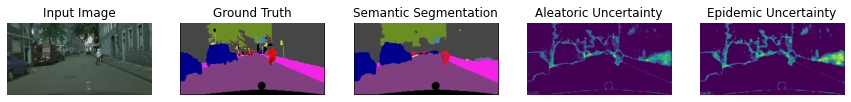

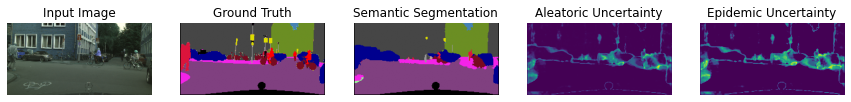

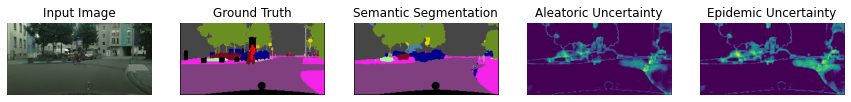

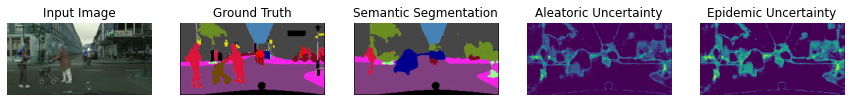

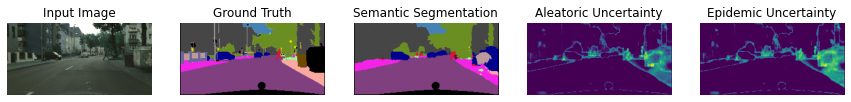

In [32]:
visualize()

## 5.2 Comment briefly on how the model’s performance could be improved.

At the begining, our team used UNet to do the segmentation. However, i tooks nearly 1.5h to train one epoch, which was unaffordable. After searching information about lightweight models, we select SegNet, which enables us to train one epoch **within minutes**.  
**The advantage of SegNet is that it don't need to save the feature maps of the entire encoder part, but only the pooling index, which greatly saves memory. Additionaly, it does not need to deconvolute or learn during the upsampling phase.**
         
Here's some strategies to improve the model's performance:  
- Since time is limited, we haven't assign different weight to each class. Considering the imbalaced data distribution, **changing the value of cate_weight**  will help.
- Increase **batch size**(using more GPUs). During training, the loss function **fluctuated** severely due to small batch size.
- Try a couple of activate functions.
- Fine-tune parameters in session 0.

# References
[1] https://blog.csdn.net/shwan_ma/article/details/100012808         
[2] https://blog.csdn.net/oYeZhou/article/details/112270908      
[3] https://blog.csdn.net/qq_32939413/article/details/112117734   
[4] Badrinarayanan, Vijay et al. “SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation.” IEEE transactions on pattern analysis and machine intelligence vol. 39,12 (2017): 2481-2495. doi:10.1109/TPAMI.2016.2644615  
[5] Kendall, A., Badrinarayanan, V., & Cipolla, R. (2015). Bayesian segnet: Model uncertainty in deep convolutional encoder-decoder architectures for scene understanding. arXiv preprint arXiv:1511.02680.